# Exercise 6b - Advanced segmentation. Fisherman's Linear discriminant analysis for segmentation


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from skimage.morphology import opening, closing
from skimage.morphology import disk

#Function given from professor 
def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W

in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

### Exercise 1
Display both the T1 and T2 images, their 1 and 2D histograms and scatter plots. Tips: Use the plt.imshow(), plt.hist(), plt.hist2d() and plt.scatter() functions Add relevant title and label for each axis. One can use plt.subplots() to show more subfigures in the same figure. Remove intensities from background voxels for 1D and 2D histograms.

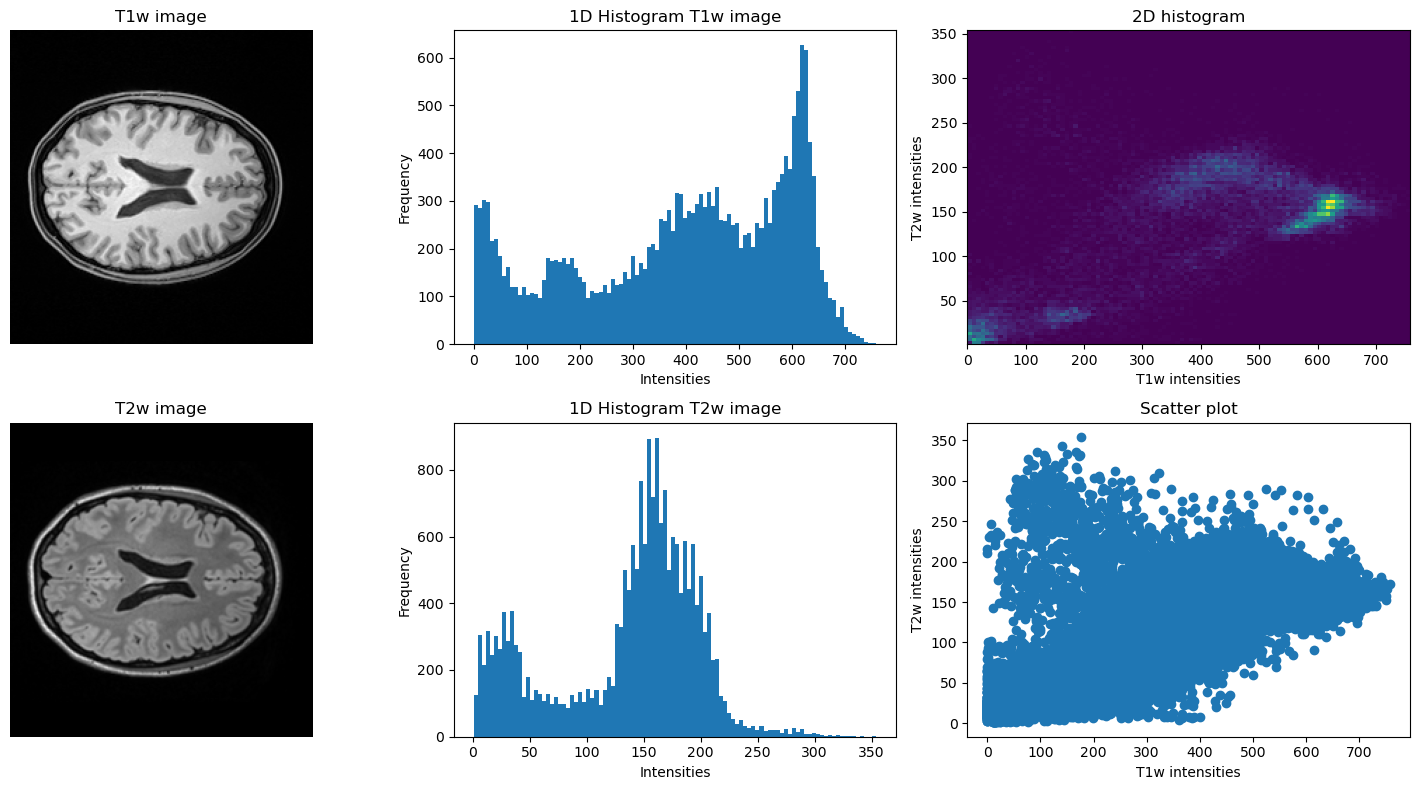

In [16]:
mask_init = ImgT1 > 10
mask = opening(mask_init, disk(2))
mask = closing(mask, disk(3))

def my_show_1D_histogram(img, mask, img_name, axs):
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title(img_name)
    axs[0].set_axis_off()

    intensities = img[mask]
    axs[1].hist(intensities, bins = 100)
    axs[1].set_title(f'1D Histogram {img_name}')
    axs[1].set_xlabel('Intensities')
    axs[1].set_ylabel('Frequency')

    return intensities

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
T1_intensities = my_show_1D_histogram(ImgT1, mask, 'T1w image', axs[0, 0:2])
T2_intensities = my_show_1D_histogram(ImgT2, mask, 'T2w image', axs[1, 0:2])
axs[0,2].hist2d(T1_intensities, T2_intensities, bins = 100)
axs[0,2].set_xlabel('T1w intensities')
axs[0,2].set_ylabel('T2w intensities')
axs[0,2].set_title('2D histogram')

axs[1,2].scatter(T1_intensities, T2_intensities)
axs[1,2].set_xlabel('T1w intensities')
axs[1,2].set_ylabel('T2w intensities')
axs[1,2].set_title('Scatter plot')
plt.tight_layout()
plt.show()

#### Q1: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms?

A1: For T1:about 500 and for T2: about 160

#### Q2: Can the GM and WM intensity classes be observed in the 2D histogram and scatter plot?

A2: Yes there appear clear two clusters with maxium intensitised in the 2D histogram that represent the two classes distributions

### Exercise 2
Place trainings examples i.e. ROI_WM and ROI_GM into variables C1 and C2 representing class 1 and class 2 respectively. Show in a figure the manually expert drawings of the C1 and C2 training examples.

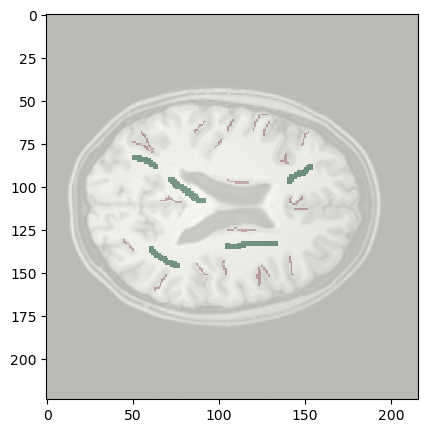

In [18]:
C1 = ROI_WM
C2 = ROI_GM
#Show the orginal with the 2 new variables 
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(C2, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(C1, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()


#### Q3: Does the ROI drawings look like what you expect from an expert?

No

### Exercise 3
For each binary training ROI find the corresponding training examples in ImgT1 and ImgT2. Later these will be extracted for LDA training.

Tips: If you are a MATLAB-like programming lover, you may use the np.argwhere() function appropriately to return the index to voxels in the image full filling e.g. intensity values >0 hence belong to a given class. Name the index variables qC1 and qC2, respectively.

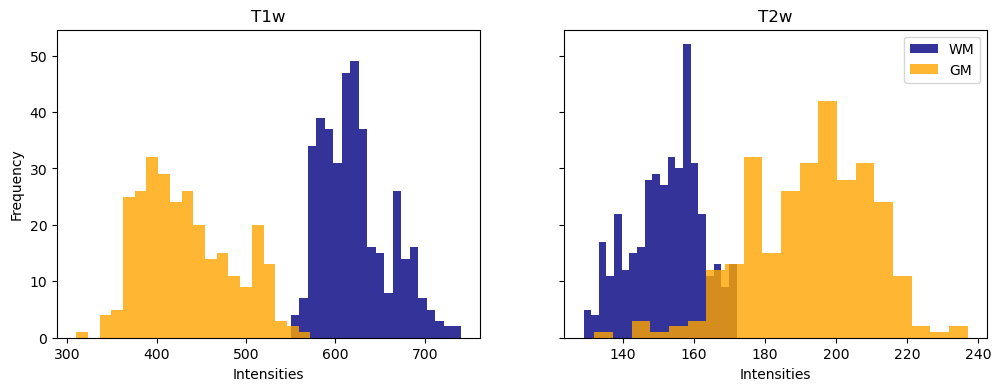

In [19]:
trainWM_T1 = ImgT1[ROI_WM] 
trainGM_T1 = ImgT1[ROI_GM] 

trainWM_T2 = ImgT2[ROI_WM] 
trainGM_T2 = ImgT2[ROI_GM] 

fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = True)
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')
plt.legend()
plt.show()

#### Q4: What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected? 

It looks very alike the full image histogram expeceptfpr better class seperation and there is no background

### Exercise 4
Make a training data vector (X) and target class vector (T) as input for the LDA() function. T and X should have the same length of data points.

X: Training data vector should first include all data points for class 1 and then the data points for class 2. Data points are the two input features ImgT1, ImgT2

T: Target class identifier for X where '0' are Class 1 and a '1' is Class 2.

In [57]:
#X_WM = np.append(trainWM_T1, trainWM_T2)
#X_GM = np.append(trainGM_T1, trainGM_T2)
#X = [X_WM, X_GM]

#TA's solution 
X1 = np.c_[trainWM_T1, trainWM_T2] 
X2 = np.c_[trainGM_T1, trainGM_T2]
X = np.r_[X1, X2]

zeros = np.zeros((len(trainWM_T1),1), dtype=int)
ones = np.ones((len(trainGM_T1),1), dtype=int)
T = np.r_[zeros,ones]
#T_t1 =np.append(np.zeros((len(trainWM_T1),1), dtype=int),np.ones((len(trainGM_T1),1), dtype=int))
print(f"X shape: {X.shape} T shape: {T.shape}")

X shape: (679, 2) T shape: (679, 1)


### Exercise 5
Make a scatter plot of the training points of the two input features for class 1 and class 2 as green and black circles, respectively. Add relevant title and labels to axis 


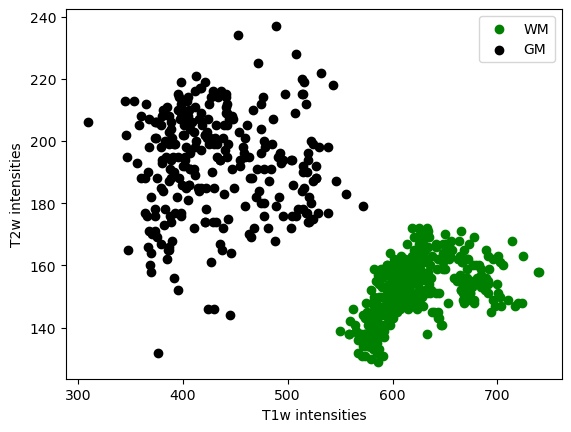

In [59]:
fig, ax = plt.subplots(1,1)
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
plt.legend()
plt.show()

#### Q5: How does the class separation appear in the 2D scatter plot compared with 1D histogram. Is it better? 
The class separation is much better in the 2D scatter plot  

### Exercise 6
Train the linear discriminant classifier using the Fisher discriminant function and estimate the weight-vector coefficient W (i.e. $\omega_0$ and $\omega$) for classification given X and T by using the W=LDA() function. The LDA function outputs W=[[w01, w1]; [w02, w2]] for class 1 and 2 respectively. 


In [61]:
W = LDA(X,T)
W

array([[-138.11536977,    0.27566672,    0.68044071],
       [-131.32787698,    0.15900268,    0.99568003]])

### Exercise 7 
Apply the linear discriminant classifier i.e. perform multi-modal classification using the trained weight-vector $W$ for each class: It calculates the linear score $Y$ for all image data points within the brain slice i.e.$y(x)=\omega + \omega_0$ actually, $y(x)$ is the $log(P(C_i|x))$.

In [63]:
Xall= np.c_[ImgT1[mask].flatten(), ImgT2[mask].flatten()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

### Exercise 8
Perform multi-modal classification: Calculate the posterior probability i.e.  of a data point belonging to class 1

In [68]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1)

### Exercise 9
Apply segmentation: Find all voxles in the T1w and T2w image with $P(X|C_1) > 0.5$ as belonging to Class 1. You may use the np.where() function. Similarly, find all voxels belonging to class 2.

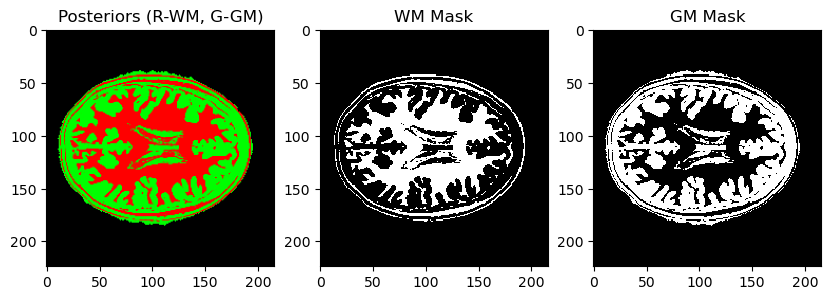

In [71]:
posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 >= 0.5
mask_GM = posteriorC2 > 0.5

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

### Exercise 10
Show scatter plot of segmentation results as in 5 

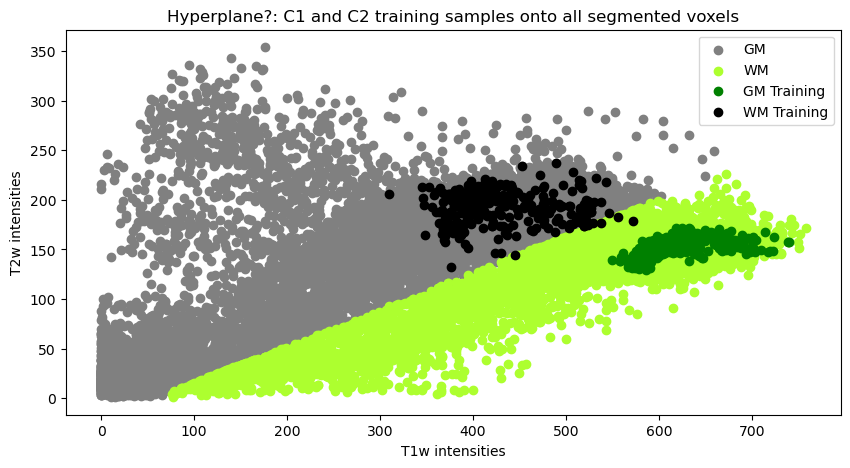

In [72]:
Xall_WM = Xall[PosteriorProb[:,0] > 0.5, :]
Xall_GM = Xall[PosteriorProb[:,1] > 0.5, :]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(Xall_GM[:,0], Xall_GM[:,1], c = 'gray', label = 'GM')
ax.scatter(Xall_WM[:,0], Xall_WM[:,1], c = 'greenyellow', label = 'WM')
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'GM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'WM Training')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
ax.set_title('Hyperplane?: C1 and C2 training samples onto all segmented voxels')
plt.legend()
plt.show()

#### Q6 Can you identify where the hyperplane is placed i.e. y(x)=0?
Yes all the points show a clear line in the hyperplane

#### Q7 Is the linear hyper plane positioned as you expected or would a non-linear hyper plane perform better?
Yes and no - I would expect all black and green training data points to be on each side of the hyperplan. Moreover the hyperplan seems to be too linear and there seem to be an extras class at the low image resolutions.

#### Q8 Would segmentation be as good as using a single image modality using thresholding?
If that should be the case the hyperplan would be orthogonal to one of the features. It is not. So no

#### Q9 From the scatter plot does the segmentation results make sense? Are the two tissue types segmented correctly.
Looks good, but hard to say from a scatter plot

### Exercise 11
#### Q10 Are the training examples representative for the segmentation results? Are you surprised that so few training examples perform so well? Do you need to be an anatomical expert to draw these?
Yes they are representative. Yes and no; one do not need to be an anatomical expert, but you need to understand what the method needs as input to perform well

#### Q11 Compare the segmentation results with the original image. Are the segmentation results satisfactory? Why not?
Yes, the WM and GM classes looks correct segmented when comparing to the anatomical structures in ImgT1 and ImgT2.

#### Q12 Is one class completely wrong segmented? What is the problem?
Yes - If you have not masked out the backgroud voxels, all background and skull voxels also are classified as GM. Solution is to identify the background voxels and exclude these from the segmentation or to add an extra class for background/skull voxels. Also the CSF class is segmented as both GM and WM. The segmentation problem is that there are more classes in the image than the classifier has been trained to segment.

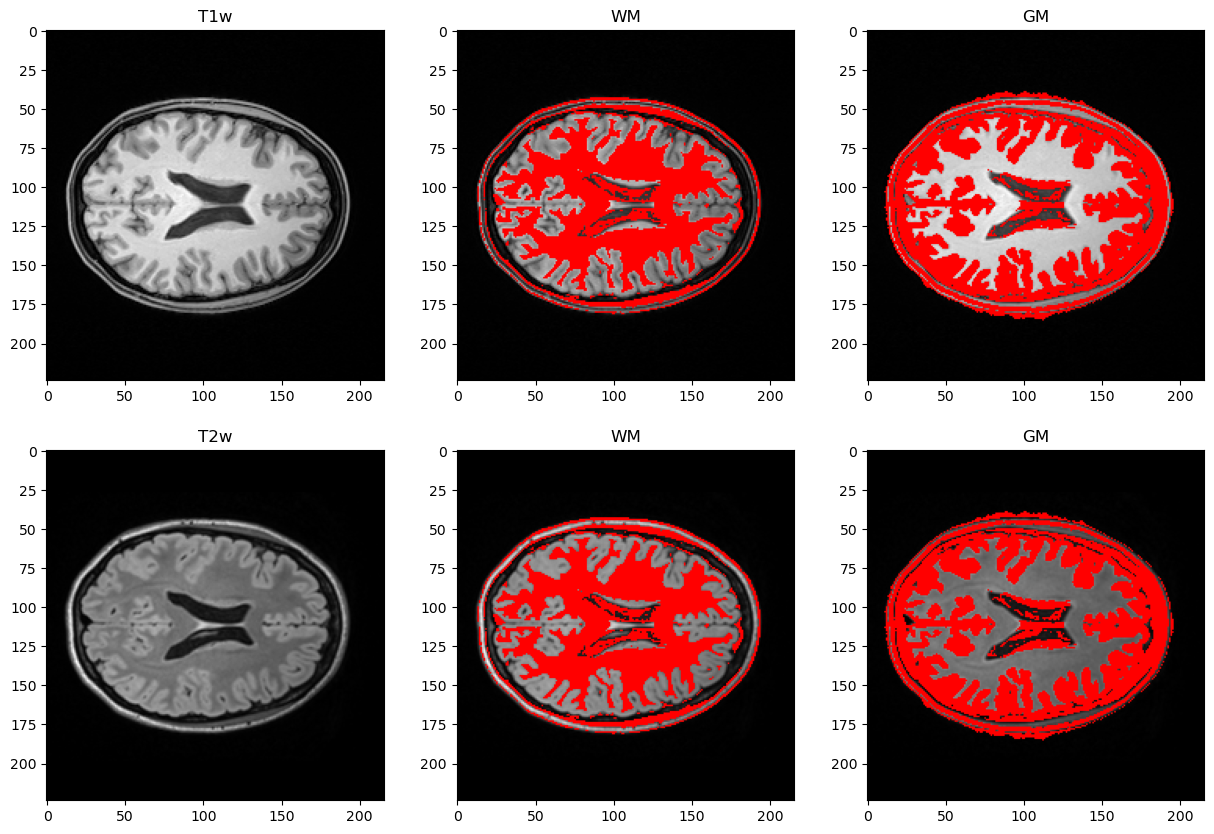

In [73]:
tmp = np.zeros(mask_WM.shape)
red_WM = np.stack((mask_WM, tmp, tmp), axis = -1)
green_GM = np.stack((tmp, mask_GM, tmp), axis = -1)

def overlay_segmentation(I, M):
    I = I/I.max()
    I_aux, I_red = I.copy(), I.copy()
    I_aux[M] = 0
    I_red[M] = 1
    tmp = np.stack((I_red, I_aux, I_aux), axis = -1)
    return tmp

fig, axs = plt.subplots(2, 3, figsize = (15, 10))
axs[0,0].imshow(ImgT1, cmap = 'gray')
axs[0,0].set_title('T1w')
axs[0,1].imshow(overlay_segmentation(ImgT1, mask_WM))
axs[0,1].set_title('WM')
axs[0,2].imshow(overlay_segmentation(ImgT1, mask_GM))
axs[0,2].set_title('GM')

axs[1,0].imshow(ImgT2, cmap = 'gray')
axs[1,0].set_title('T2w')
axs[1,1].imshow(overlay_segmentation(ImgT2, mask_WM))
axs[1,1].set_title('WM')
axs[1,2].imshow(overlay_segmentation(ImgT2, mask_GM))
axs[1,2].set_title('GM')

plt.show()